In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import ntpath 
import re 
import sys
import pickle
sys.path.append(r'../.')
from commons.data_processing import * 
from commons.my_mzml import *
from commons.DataProcessors.byonic import ByFile

In [2]:
# get byonic output files
files = get_files('.', exts=['.xlsx'])

# get xml files
xmls = get_files(r"C:\Users\graha\Desktop\LocalData\EnrGly", exts=['.mzXML'])

In [37]:
# create pandas dataframe from byonic output of all runs 
all_runs = pd.DataFrame()
for file in files[:]:
    source, _ = ntpath.splitext(ntpath.basename(file))
    bf = ByFile(file)
    bf.fill_no_glycans()
    bf.remove_reverse(modify=True)
    bf.determine_glycosites()
    bf.filter_hits(score=100, modify=True)
    subset = ["clean_peptide", "glycan", "z", "observed_mz",
              "calc._mass_mh", "glycosite", "score", "delta_mod",
              "log_prob", "peptide","protein_name", "scan_time"]
    bf.frame = bf.reduce_frame(cols=subset, gp_only=True)
    bf.frame['source'] = [source]*len(bf.frame)
    bf.frame.sort_values('z', inplace=True)
    total = bf.total_gp()
    unique = bf.unique_gp()
    if all_runs.empty:
        all_runs = unique
    else:
        all_runs = pd.concat([all_runs, unique])

In [38]:
#pull example
all_runs[all_runs.peptide=='R.N[+1378.476]LTK.D']

,clean_peptide,glycan,z,observed_mz,calc._mass_mh,glycosite,score,delta_mod,log_prob,peptide,protein_name,scan_time,source
4395,NLTK,HexNAc(2)Hex(6),2,927.3910,1853.7632,61,313.43,313.43,4.56,R.N[+1378.476]LTK.D,>sp|P61823|RNAS1_BOVIN Ribonuclease pancreatic...,22.7848,BP_30C
4745,NLTK,HexNAc(2)Hex(6),2,927.3916,1853.7632,61,313.89,313.89,3.61,R.N[+1378.476]LTK.D,>sp|P61823|RNAS1_BOVIN Ribonuclease pancreatic...,19.5644,BP_45C
4836,NLTK,HexNAc(2)Hex(6),2,927.3899,1853.7632,61,188.08,188.08,1.45,R.N[+1378.476]LTK.D,>sp|P61823|RNAS1_BOVIN Ribonuclease pancreatic...,18.1034,BP_60C
7239,NLTK,HexNAc(2)Hex(6),2,927.3913,1853.7632,61,312.21,312.21,5.61,R.N[+1378.476]LTK.D,>sp|P61823|RNAS1_BOVIN Ribonuclease pancreatic...,6.0586,C18_30C
7111,NLTK,HexNAc(2)Hex(6),2,927.3905,1853.7632,61,350.66,350.66,5.13,R.N[+1378.476]LTK.D,>sp|P61823|RNAS1_BOVIN Ribonuclease pancreatic...,4.9680,C18_45C
7485,NLTK,HexNAc(2)Hex(6),2,927.3921,1853.7632,61,325.09,325.09,5.45,R.N[+1378.476]LTK.D,>sp|P61823|RNAS1_BOVIN Ribonuclease pancreatic...,5.0239,C18_60C
6138,NLTK,HexNAc(2)Hex(6),2,927.3881,1853.7632,61,404.01,404.01,5.70,R.N[+1378.476]LTK.D,>sp|P61823|RNAS1_BOVIN Ribonuclease pancreatic...,19.0064,PGC_30C
5192,NLTK,HexNAc(2)Hex(6),2,927.3874,1853.7632,61,329.28,329.28,4.36,R.N[+1378.476]LTK.D,>sp|P61823|RNAS1_BOVIN Ribonuclease pancreatic...,18.3852,PGC_45C
4914,NLTK,HexNAc(2)Hex(6),2,927.3883,1853.7632,61,334.29,334.29,4.27,R.N[+1378.476]LTK.D,>sp|P61823|RNAS1_BOVIN Ribonuclease pancreatic...,16.6874,PGC_60C


In [6]:
source_dict = {}
for x in xmls:
    base = ntpath.basename(x)
    key = '_'.join(x.split('_')[-3:-1])
    print(key, base)
    m = mzXML(x)
    source_dict[key] = m.ms1_data

BP_30C 20201115_GD_EnrGly_1115_BP_30C_run1.mzXML
BP_45C 20201115_GD_EnrGly_1115_BP_45C_run1.mzXML
BP_60C 20201115_GD_EnrGly_1115_BP_60C_run1.mzXML
C18_30C 20201115_GD_EnrGly_1115_C18_30C_run1.mzXML
C18_45C 20201115_GD_EnrGly_1115_C18_45C_run1.mzXML
C18_60C 20201115_GD_EnrGly_1115_C18_60C_run1.mzXML
PGC_30C 20201115_GD_EnrGly_1115_PGC_30C_run1.mzXML
PGC_45C 20201115_GD_EnrGly_1115_PGC_45C_run1.mzXML
PGC_60C 20201115_GD_EnrGly_1115_PGC_60C_run1.mzXML


In [7]:
subset = ['PGC_30C', 'PGC_45C', 'PGC_60C',
          'C18_30C', 'C18_45C', 'C18_60C']
pc = all_runs[all_runs.source.isin(subset)]
counts = pc.peptide.value_counts()
pc = pc[pc.peptide.isin(counts[counts==6].keys())]
pc

,clean_peptide,glycan,z,observed_mz,calc._mass_mh,glycosite,score,delta_mod,log_prob,peptide,protein_name,source
1068,CVYNCSFIK,HexNAc(3)Hex(6),2,1407.5630,2814.0989,95,205.49,204.84,3.35,K.[+42.011]C[+57.021]VYN[+1581.555]C[+57.021]S...,>sp|Q3SZR3|A1AG_BOVIN Alpha-1-acid glycoprotei...,C18_30C
6774,SRNLTK,HexNAc(2)Hex(6),2,1048.9573,2096.8963,61,280.48,97.80,3.14,K.SRN[+1378.476]LTK.D,>sp|P61823|RNAS1_BOVIN Ribonuclease pancreatic...,C18_30C
6776,SRNLTK,HexNAc(2)Hex(8),2,1211.0112,2421.0019,61,281.18,90.00,1.58,K.SRN[+1702.581]LTK.D,>sp|P61823|RNAS1_BOVIN Ribonuclease pancreatic...,C18_30C
1489,CVYNCSFIK,HexNAc(4)Hex(5),2,1407.0691,2813.1149,95,564.93,519.64,9.49,K.C[+57.021]VYN[+1622.582]C[+57.021]SFIK.I,>sp|Q3SZR3|A1AG_BOVIN Alpha-1-acid glycoprotei...,C18_30C
6779,SRNLTK,HexNAc(2)Hex(5),2,967.9313,1934.8435,61,282.24,85.26,1.58,K.SRN[+1216.423]LTK.D,>sp|P61823|RNAS1_BOVIN Ribonuclease pancreatic...,C18_30C
...,...,...,...,...,...,...,...,...,...,...,...,...
1141,QNGTLSK,HexNAc(4)Hex(5)NeuAc(1)NeuGc(1),3,990.0647,2968.1669,105,225.40,140.42,5.22,R.QN[+2220.767]GTLSK.V,>sp|Q3SZR3|A1AG_BOVIN Alpha-1-acid glycoprotei...,PGC_60C
1074,IYRQNGTLSK,HexNAc(4)Hex(5)Fuc(1),3,983.4378,2948.2876,105,428.01,428.01,6.09,K.IYRQN[+1768.640]GTLSK.V,>sp|Q3SZR3|A1AG_BOVIN Alpha-1-acid glycoprotei...,PGC_60C
1381,TFMLAASWNGTK,HexNAc(4)Hex(5)Fuc(1),3,1032.4380,3095.2906,137,392.94,172.79,7.13,R.TFMLAASWN[+1768.640]GTK.N,>sp|Q3SZR3|A1AG_BOVIN Alpha-1-acid glycoprotei...,PGC_60C
2460,LCPDCPLLAPLNDSR,HexNAc(6)Hex(3)Fuc(1)NeuAc(2),4,1044.4446,4173.7242,157,109.04,109.04,1.83,K.LC[+57.021]PDC[+57.021]PLLAPLN[+2432.884]DSR.V,>sp|P12763|FETUA_BOVIN Alpha-2-HS-glycoprotein...,PGC_60C


In [11]:
def extract(mass_dict, search_mass, tolerance=10):
    xs, ys = [], []
    low, high = mass_tolerance(search_mass, tolerance)
    for _, scan in enumerate(mass_dict):
        xs.append(scan[0])
        precs = scan[1]
        ids = np.where(np.logical_and(precs >= low, precs <= high))
        if len(ids[0]) > 0:
            ys.append(np.max(scan[2][ids]))
        else:
            ys.append(0)
    return np.array(xs), np.array(ys)

In [44]:
subset = ['PGC_30C', 'PGC_45C', 'PGC_60C',
          'C18_30C', 'C18_45C', 'C18_60C']
pc = all_runs[all_runs.source.isin(subset)]
counts = pc.peptide.value_counts()
pc = pc[pc.peptide.isin(counts[counts==6].keys())]

In [13]:
subset = ['PGC_30C', 'PGC_45C', 'PGC_60C',
          'C18_30C', 'C18_45C', 'C18_60C']
pc = all_runs[all_runs.source.isin(subset)]
counts = pc.peptide.value_counts()
pc = pc[pc.peptide.isin(counts[counts==6].keys())]


pickle_filename = 'EnrGly_EICs_PC.p'

if os.path.exists(pickle_filename):
    d = pickle.load(open(pickle_filename, 'rb'))
else:
    d = {}
    for r in pc.peptide.unique():
        sub = pc[pc.peptide==r]
        s = {}
        s['sequence'] = sub.clean_peptide.unique()
        s['glycan'] = sub.glycan.unique()
        s['masses'] = sub.observed_mz.values
        s['charges'] = sub.z.values
        s['sources'] = sub.source.values
        s['scan_times'] = sub.scan_time.values
        s['arrays'] = []
        d[r] = s

    for peptide in d:
        print(peptide)
        for i, source in enumerate(d[peptide]['sources']):
            print(source)
            mass_dict = source_dict[source]
            mass = d[peptide]['masses'][i]
            xs, ys = extract(mass_dict, mass, tolerance=10)
            d[peptide]['arrays'].append((xs, ys))
    pickle.dump(d, open(pickle_filename, 'wb'))

K.[+42.011]C[+57.021]VYN[+1581.555]C[+57.021]SFIK.I
C18_30C
C18_45C
C18_60C
PGC_30C
PGC_45C
PGC_60C
K.SRN[+1378.476]LTK.D
C18_30C
C18_45C
C18_60C
PGC_30C
PGC_45C
PGC_60C
K.SRN[+1702.581]LTK.D
C18_30C
C18_45C
C18_60C
PGC_30C
PGC_45C
PGC_60C
K.C[+57.021]VYN[+1622.582]C[+57.021]SFIK.I
C18_30C
C18_45C
C18_60C
PGC_30C
PGC_45C
PGC_60C
K.SRN[+1216.423]LTK.D
C18_30C
C18_45C
C18_60C
PGC_30C
PGC_45C
PGC_60C
K.SRN[+730.264]LTK.D
C18_30C
C18_45C
C18_60C
PGC_30C
PGC_45C
PGC_60C
K.SRN[+1540.529]LTK.D
C18_30C
C18_45C
C18_60C
PGC_30C
PGC_45C
PGC_60C
R.NPEYN[+1622.582]K.S
C18_30C
C18_45C
C18_60C
PGC_30C
PGC_45C
PGC_60C
K.SRN[+1054.370]LTK.D
C18_30C
C18_45C
C18_60C
PGC_30C
PGC_45C
PGC_60C
K.SRN[+1864.634]LTK.D
C18_30C
C18_45C
C18_60C
PGC_30C
PGC_45C
PGC_60C
R.NPEYN[+1257.449]K.S
C18_30C
C18_45C
C18_60C
PGC_30C
PGC_45C
PGC_60C
R.QN[+1622.582]GTLSK.V
C18_30C
C18_45C
C18_60C
PGC_30C
PGC_45C
PGC_60C
R.NPEYN[+1913.677]K.S
C18_30C
C18_45C
C18_60C
PGC_30C
PGC_45C
PGC_60C
R.NPEYN[+2204.772]K.S
C18_30C
C18_45C
C

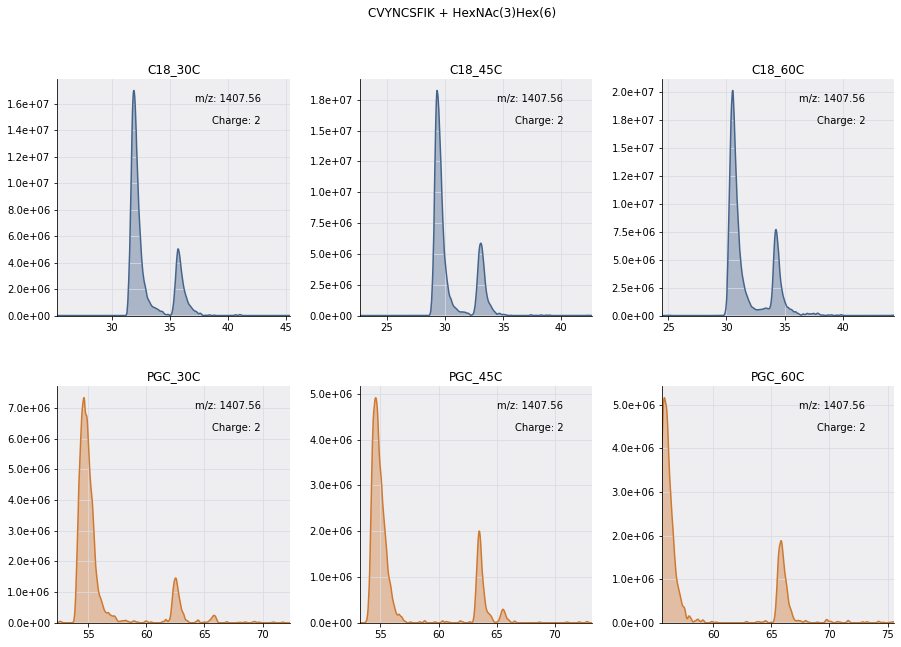

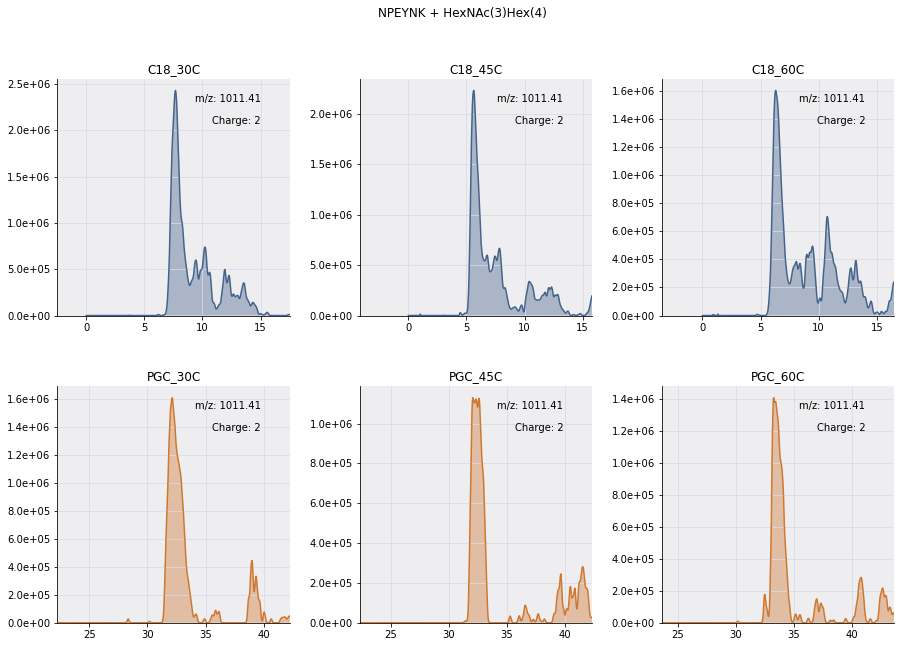

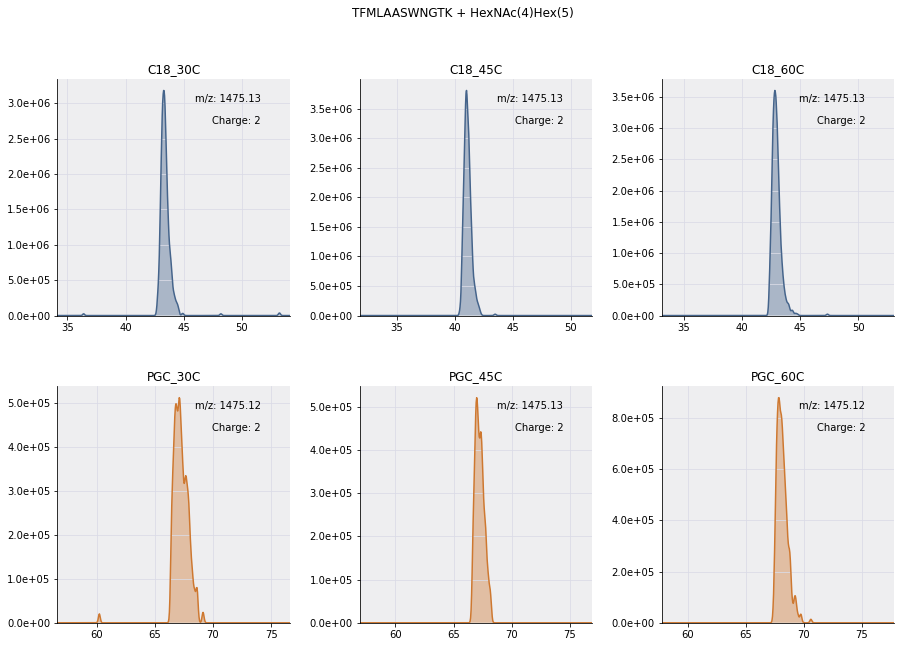

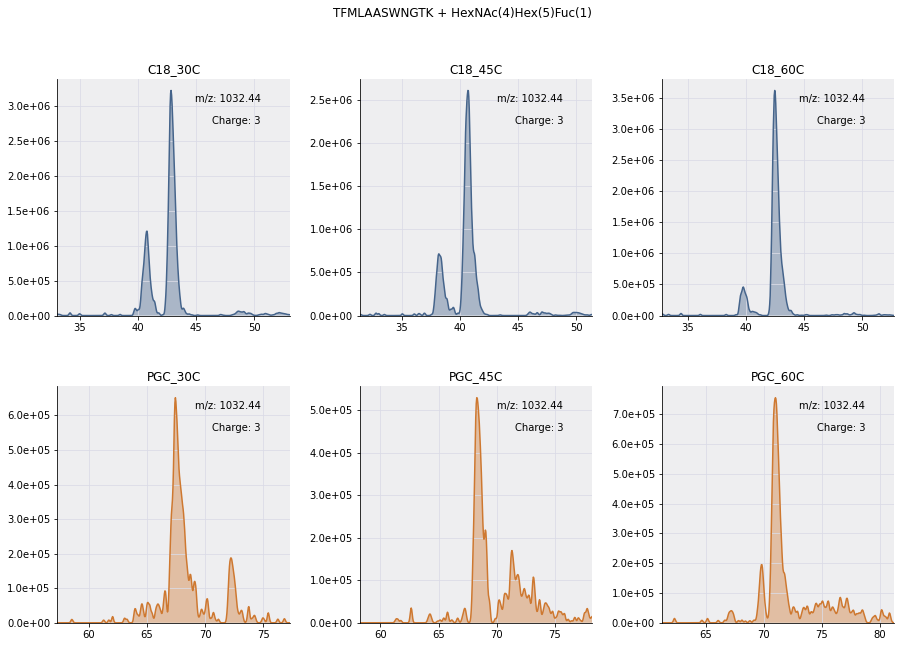

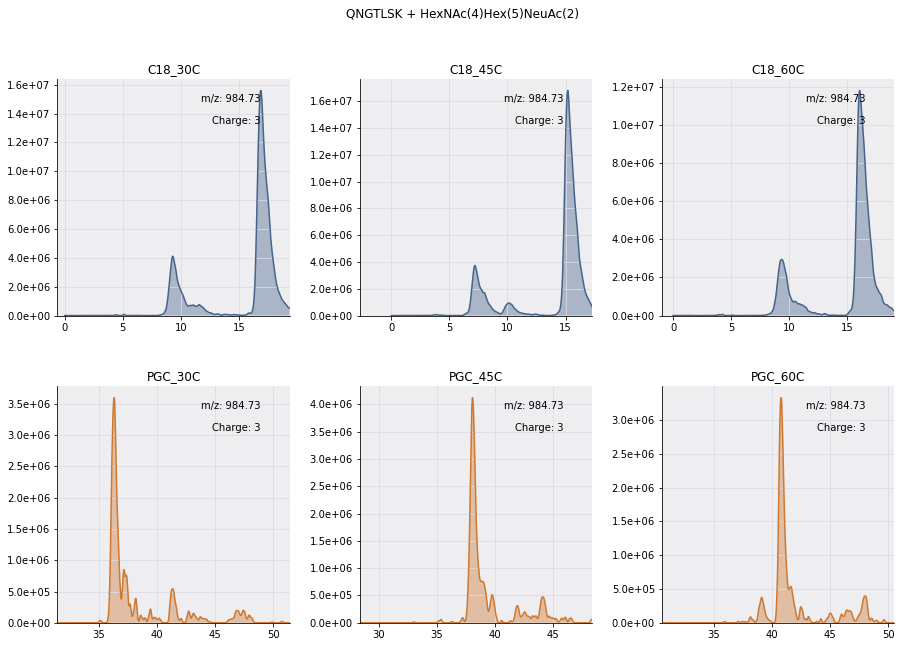

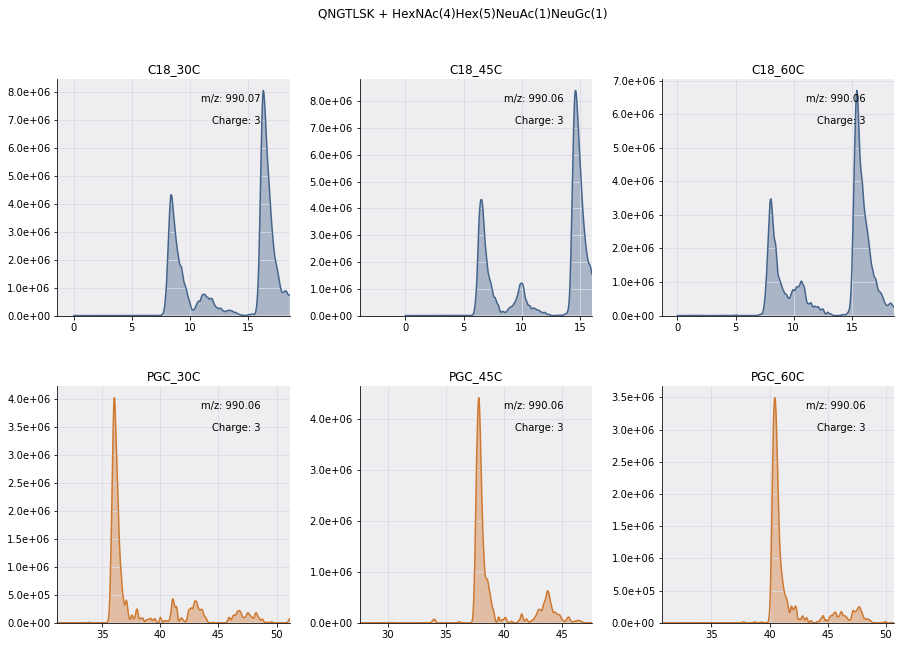

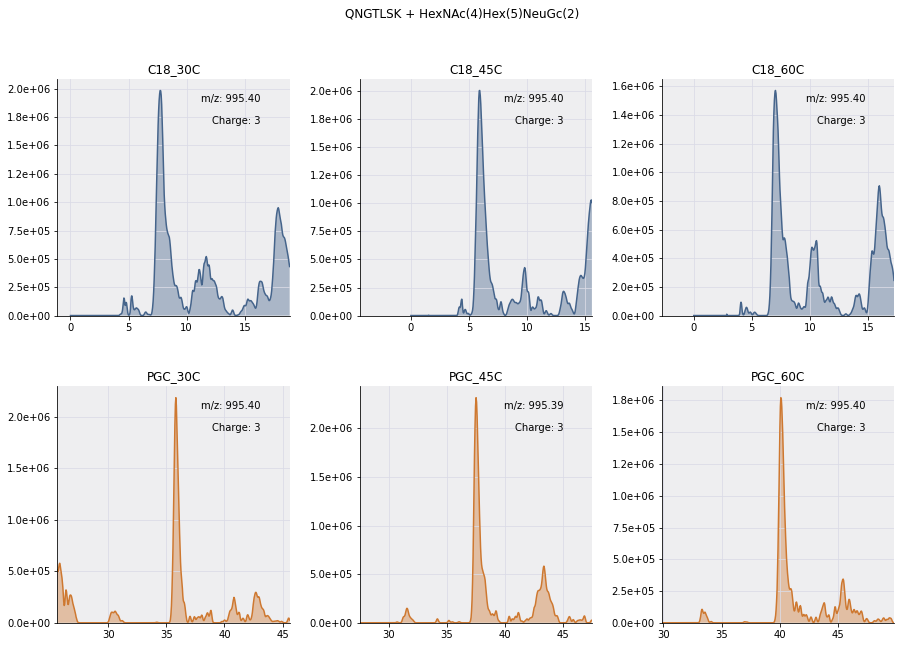

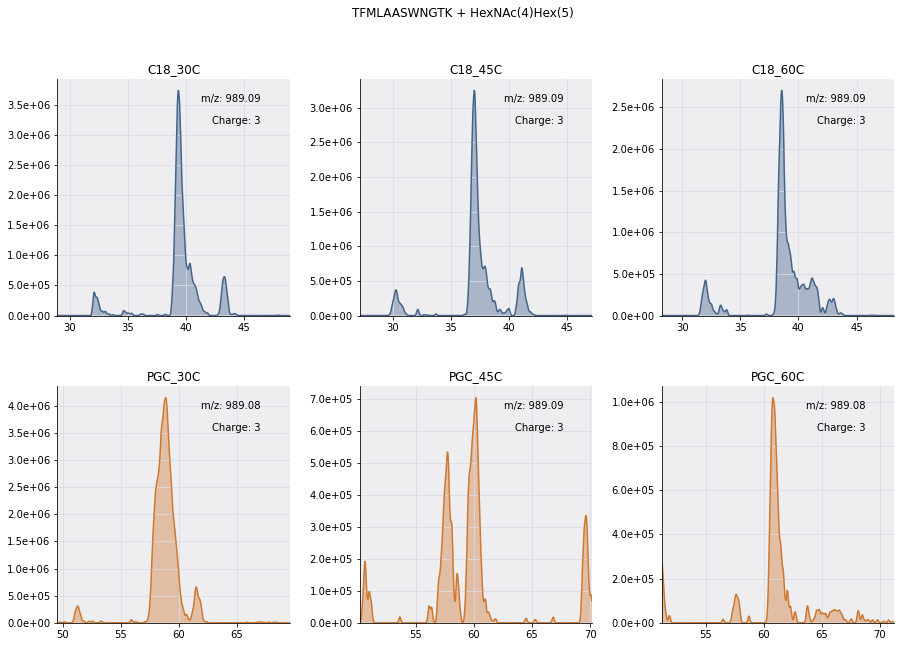

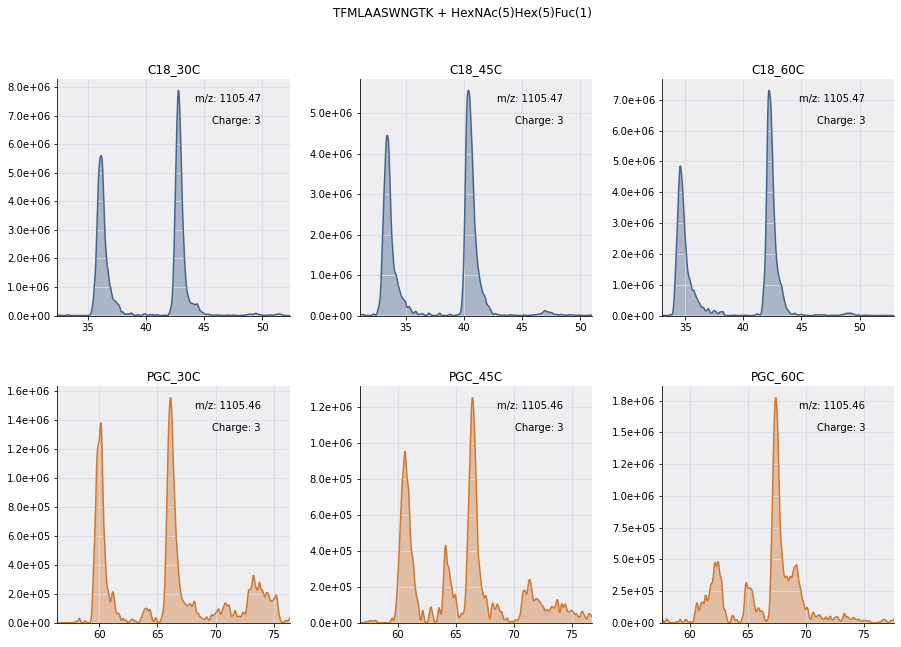

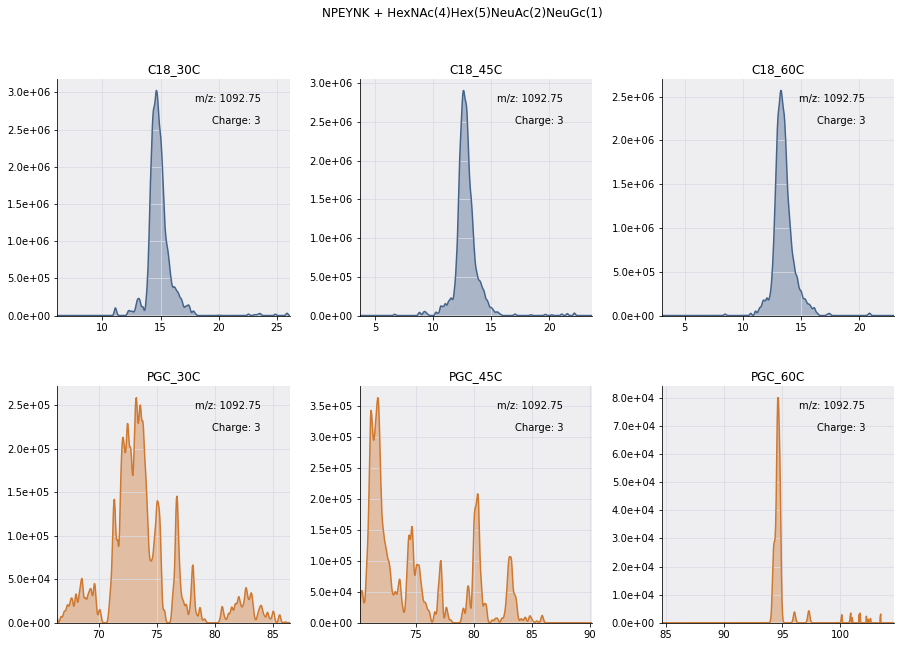

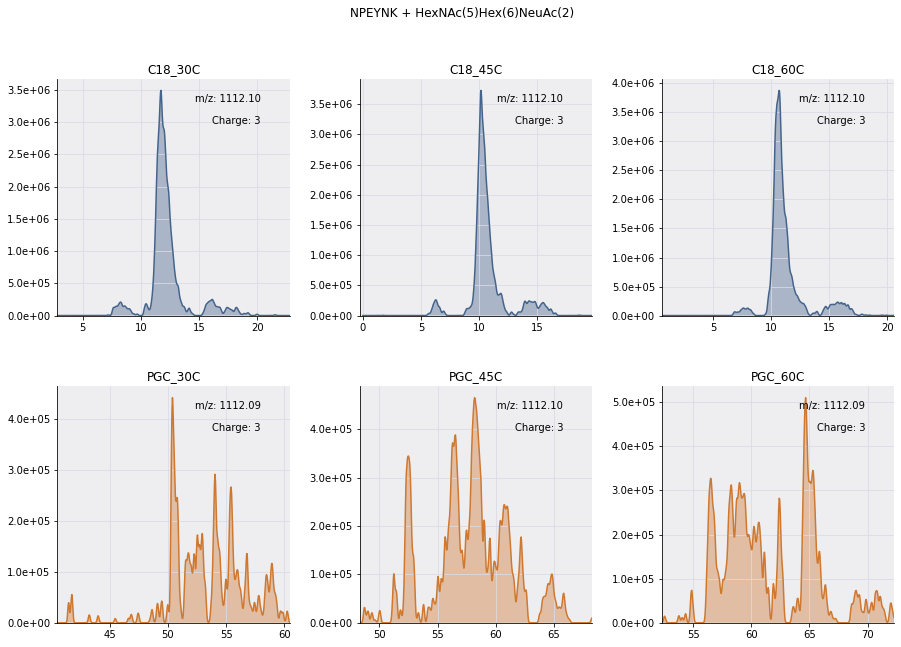

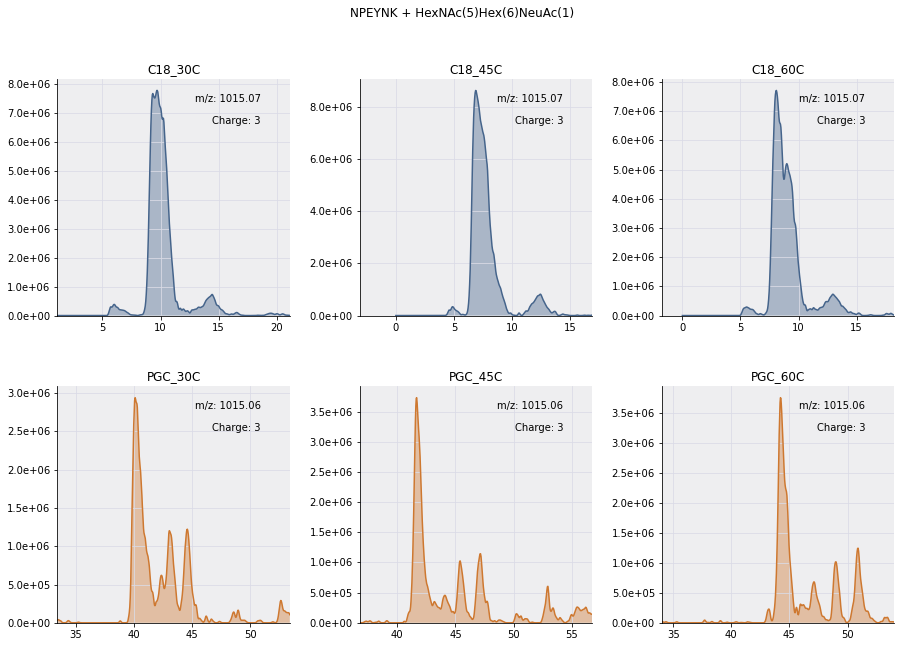

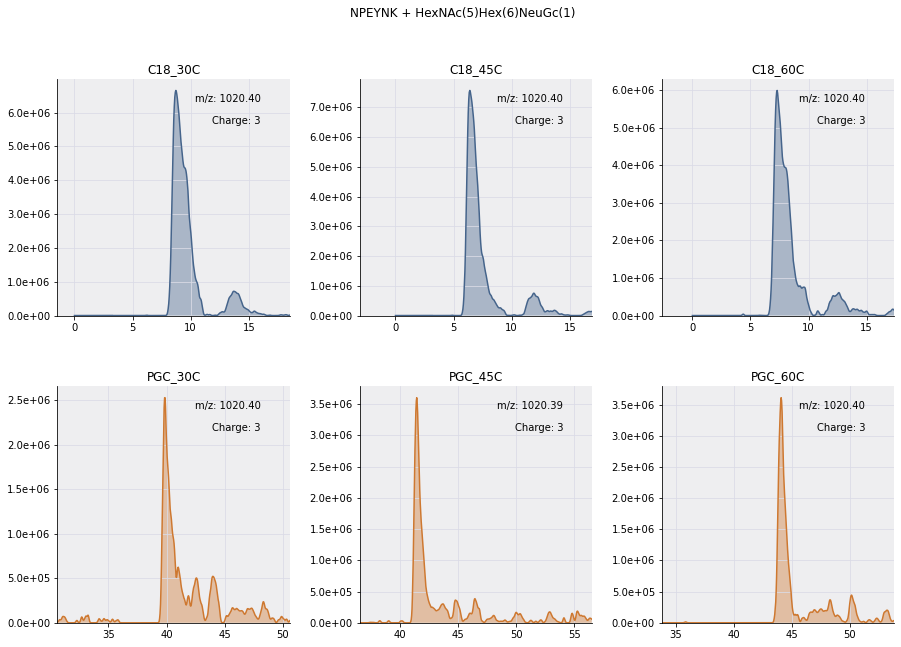

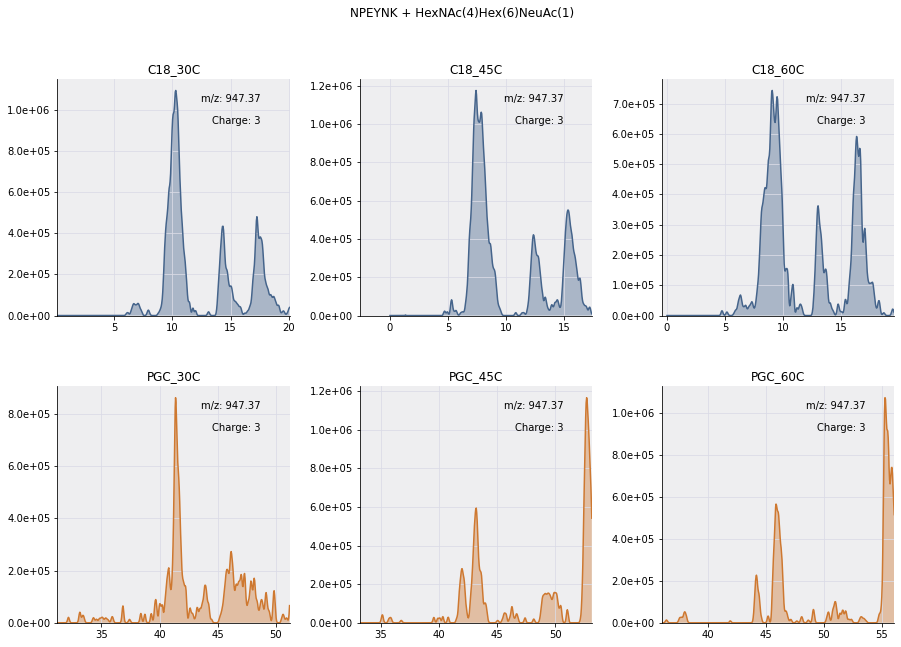

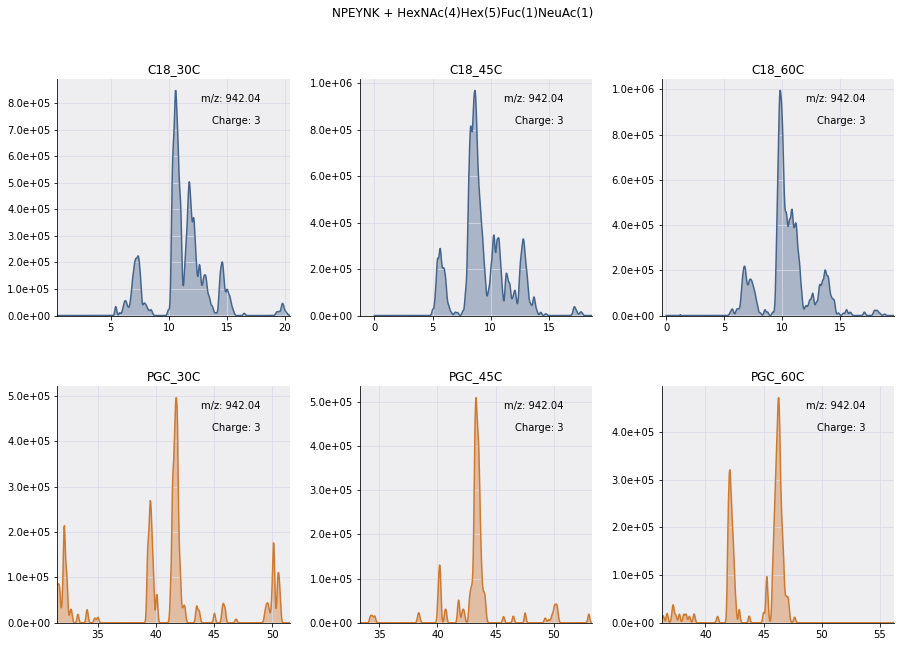

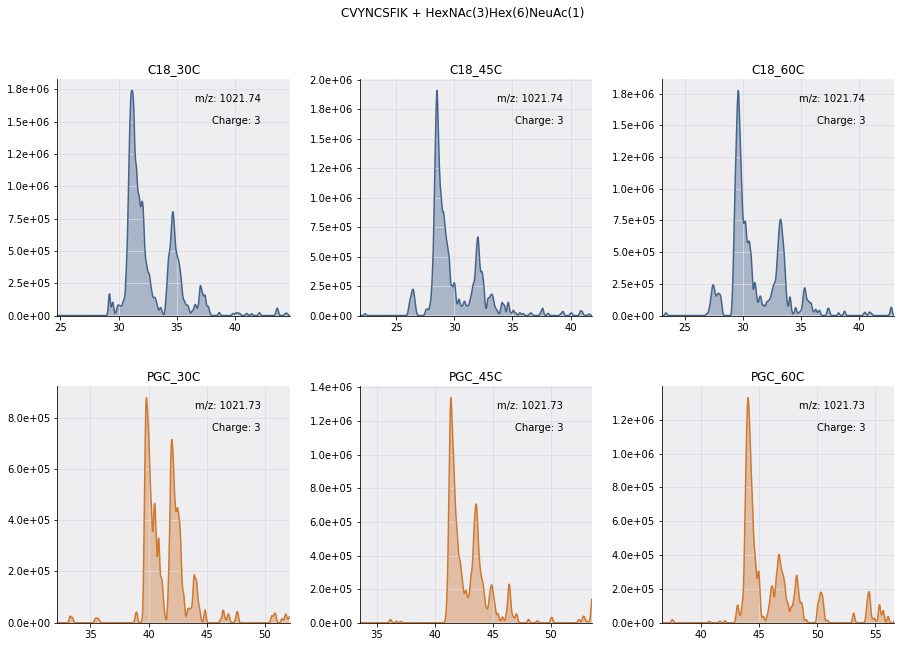

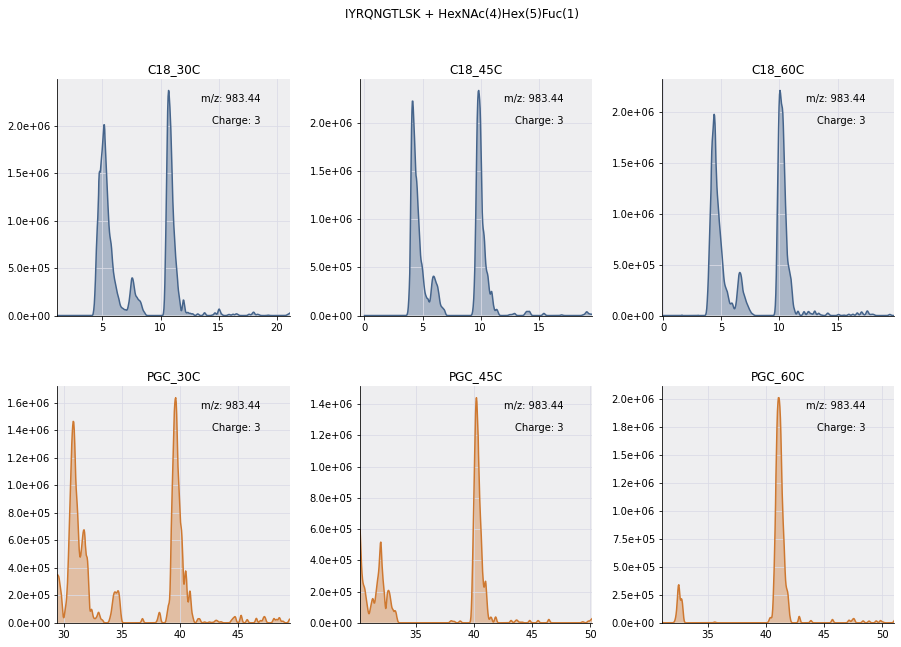

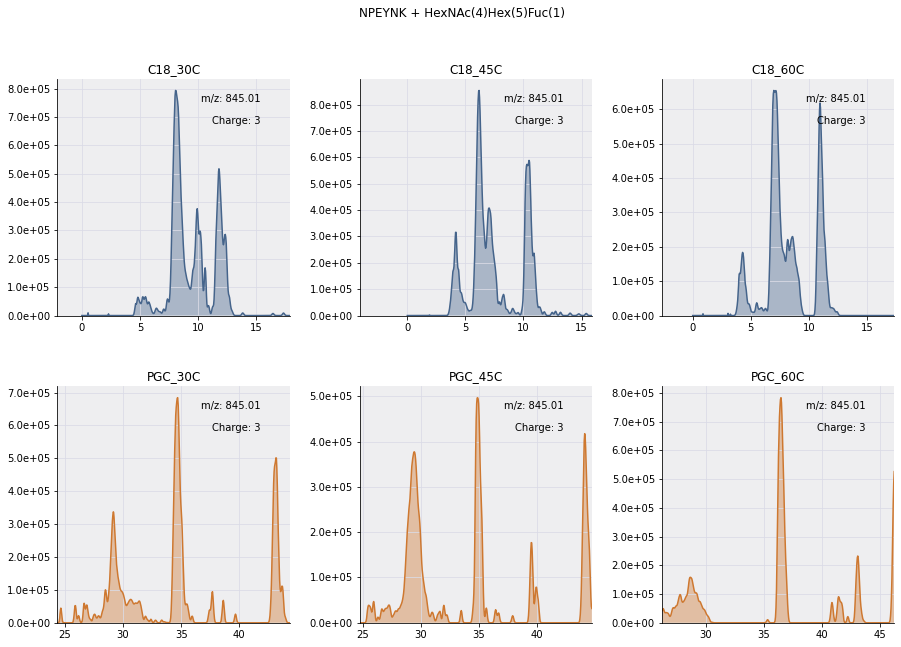

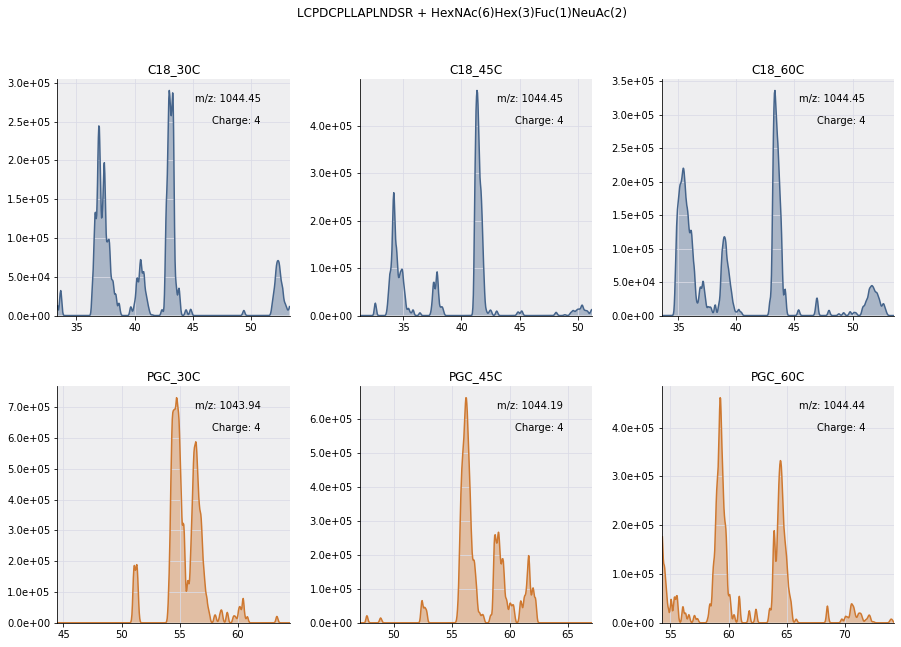

In [53]:
color_dict = {
    'BP':'#88868F',
    'C18':'#45648B',
    'PGC':'#CE7830'
}

# check peptides from PGC/C18 list and make sure
# they are not also in PGC/C18/BPlist
s = pickle.load(open('EnrGly_EICs_bpc.p', 'rb'))
pep_list = [pep for pep in d if pep not in s ]
    

for peptide in pep_list:
    data = d[peptide]['arrays']
    masses = d[peptide]['masses']
    charges = d[peptide]['charges']
    sources = d[peptide]['sources']
    glycan = d[peptide]['glycan'][0]
    sequence = d[peptide]['sequence'][0]
    times = d[peptide]['scan_times']

    title = sequence + ' + ' + glycan

    fig, axs = plt.subplots(2, 3, figsize=(15,10))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    for i, ax in enumerate(axs.flat):
        arr = data[i]
        time = times[i]
        xs, ys = arr[0], arr[1]
        ys = gaussian_filter(ys, 2)
        t_range = np.where(np.logical_and(xs >= time-10, xs <= time+10))
        xs, ys = xs[t_range], ys[t_range]
        idx = np.where(ys == np.max(ys))
        

        # ax = axs[i % 3][i // 3]
        # plot data
        ax = axs.flat[i]
        color = color_dict[sources[i].split('_')[0]]
        ax.plot(xs, ys, color=color)
        ax.fill_between(xs, 0, ys, facecolor=color, alpha=0.4)
        ax.set_xlim(time-10, time+10)
        ax.set_ylim(0, max(ys)*1.05)

        # add identifying text
        ax.set_title(sources[i])
        ax.text(time+7.5, max(ys)*.95, f'm/z: {masses[i]:.2f}', ha='right')
        ax.text(time+7.5, max(ys)*.85, f'Charge: {charges[i]}', ha='right')

        # format plots
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
        ax.set_facecolor('#EEEEF0')
        ax.grid(True, color='#dadbe6')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        fig.suptitle(title)
    plt.savefig('./MS1_Traces/PC/'+title+'.png')
    plt.savefig('./MS1_Traces/PC/'+title+'.svg')

In [49]:
for pep in d:
    sub = pc[pc.peptide==pep]
    d[pep]['scan_times'] = sub.scan_time.values